In [22]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.models as models
import torch.nn as nn
import torchvision.models as tvm
resnet = tvm.resnet18(weights=tvm.ResNet18_Weights.IMAGENET1K_V1)
import glob
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import random
import sys
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [23]:
in_channels = 3

In [24]:
class MRIDataset(Dataset):
    def __init__(self, root="Data/brain_tumor_dataset", img_size=128, mode="t):

        self.mode = "train"
        
        self.tumor, self. = []
        self.healthy = []
        for f in glob.iglob("./Data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            self.tumor.append(img)
        for f in glob.iglob("./Data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            self.healthy.append(img)

        self.tumor = np.array(self.tumor,dtype=np.float32)
        self.healthy = np.array(self.healthy,dtype=np.float32)

        self.tumor_labels = np.ones(self.tumor.shape[0], dtype=np.float32)
        self.healthy_labels = np.zeros(self.healthy.shape[0], dtype=np.float32)

        self.images = np.concatenate((self.tumor, self.healthy), axis=0)
        self.labels = np.concatenate((self.tumor_labels, self.healthy_labels), axis=0)

    def train_test_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
            

    def __len__(self):
        if self.mode == "train":
            return self.X_train.shape[0]
        elif self.mode == "val":
            return self.X_val.shape[0]
            
    def __getitem__(self, index):
        if self.mode == "train":
            sample = {"image": self.X_train[index], "label": self.y_train[index]}
            return sample
        elif self.mode == "val":
            sample = {"image": self.X_val[index], "label": self.y_val[index]}
            return sample
    
    def normalize(self):
        self.images = self.images/255.0 

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),           
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),         
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(128, 128, kernel_size=3, padding=1),        
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
        )
        self.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*8*8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(256, 1)  
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x  

def resnet18_binary(in_channels=1, pretrained=True):
    w = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    m = models.resnet18(weights=w)
    if in_channels == 1:
        m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    m.fc = nn.Linear(m.fc.in_features, 1)  # logits
    return m

In [26]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_test_split()

In [27]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [28]:
device = torch.device("cpu")
use_resnet = True
model = resnet18_binary(3, pretrained=True) if use_resnet else CNN(in_channels).to_device()

In [29]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [30]:
epoch_train_loss = []
epoch_val_loss = []

In [31]:
criterion = nn.BCEWithLogitsLoss()   # <- use this instead of BCELoss

for epoch in range(1, 500):
    train_losses = []
    model.train()
    mri_dataset.mode = 'train'

    for D in train_dataloader:
        optimizer.zero_grad()
        data  = D['image'].to(device)                     # [B, C, H, W]
        label = D['label'].to(device).float().view(-1)    # [B], floats 0/1

        logits = model(data).view(-1)                     # [B]
        loss   = criterion(logits, label)                 # no sum()

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # ----- validation -----
    val_losses = []
    model.eval()
    mri_dataset.mode = 'val'

    with torch.no_grad():
        for D in val_dataloader:
            data  = D['image'].to(device)
            label = D['label'].to(device).float().view(-1)

            logits = model(data).view(-1)
            loss   = criterion(logits, label)
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print(f"Train Epoch: {epoch+1}\tTrain Loss: {np.mean(train_losses):.6f}\tVal Loss: {np.mean(val_losses):.6f}")
    

KeyboardInterrupt: 

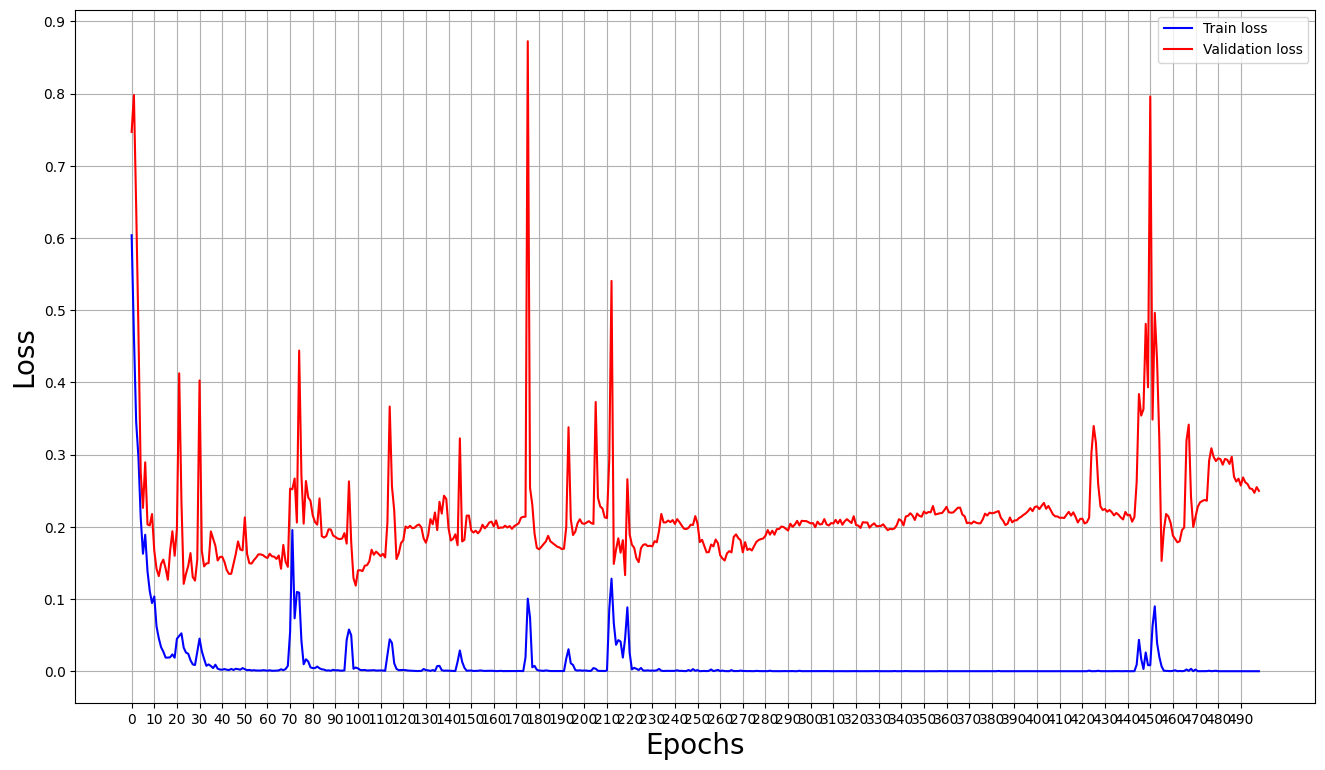

In [21]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label='Validation loss')
plt.legend()
plt.grid()


plt.xticks(np.arange(0, len(epoch_train_loss)+1, 10))  
plt.yticks(np.arange(0, max(max(epoch_train_loss), max(epoch_val_loss))+0.1, 0.1))

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.show()

In [25]:
criterion = nn.BCEWithLogitsLoss()  

number_of_epochs = 70

for epoch in range(number_of_epochs):
    train_losses = []
    model.train()
    mri_dataset.mode = 'train'

    for D in train_dataloader:
        optimizer.zero_grad()
        data  = D['image'].to(device)                     
        label = D['label'].to(device).float().view(-1)    

        logits = model(data).view(-1)                    
        loss = criterion(logits, label)     
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1/number_of_epochs} - mean loss: {np.mean(train_losses): .6f}")

Epoch 9.014285714285714 - mean loss:  0.000358
Epoch 19.014285714285716 - mean loss:  0.000012
Epoch 29.014285714285716 - mean loss:  0.000009
Epoch 39.01428571428571 - mean loss:  0.000007
Epoch 49.01428571428571 - mean loss:  0.000004
Epoch 59.01428571428571 - mean loss:  0.000021
Epoch 69.01428571428572 - mean loss:  0.000006


In [30]:
def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    x = np.array(scores)
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [33]:
outputs = []
y_true = []

model.eval()
mri_dataset.mode = 'val'

with torch.no_grad():
     for D in val_dataloader:
        data  = D['image'].to(device)
        label = D['label'].to(device).float().view(-1)
        
        logits = model(data).view(-1)

        y_true.append(label.cpu().detach().numpy())
        outputs.append(logits.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()



In [34]:
accuracy_score(y_true, threshold(outputs))

0.9550561797752809